In [100]:
from qiskit import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
from qiskit.providers.aer.noise.errors.standard_errors import coherent_unitary_error
from qiskit.providers.aer.noise import NoiseModel
from qiskit.ignis.characterization.gates import (AmpCalFitter, ampcal_1Q_circuits,
                                                 AngleCalFitter, anglecal_1Q_circuits,
                                                 AmpCalCXFitter, ampcal_cx_circuits,
                                                 AngleCalCXFitter, anglecal_cx_circuits)
backend = provider.get_backend('ibmqx2')

ibmqfactory.load_account:WARNING:2020-07-10 16:07:59,452: Credentials are already in use. The existing account in the session will be replaced.


$$U_3 = Z_\text{something}(Z_{-\lambda +\theta -\frac{\pi}{2}}X_{\frac{\pi}{2}}Z_{\lambda -\theta +\frac{\pi}{2}})(Z_{\frac{\pi}{2}-\lambda}X_{\frac{\pi}{2}}Z_{\lambda - \frac{\pi}{2}})$$
$$U_2 = Z_{\lambda - \phi}(Z_{-\lambda}X_{\frac{\pi}{2}}Z_{\lambda})$$


In [76]:
qubits = [0]
circs, xdata = ampcal_1Q_circuits(50, qubits)

In [77]:
# Set the simulator
# Add a rotation error
err_unitary = np.zeros([2,2],dtype=complex)
angle_err = 0.1
for i in range(2):
    err_unitary[i,i] = np.cos(angle_err)
    err_unitary[i,(i+1) % 2] = np.sin(angle_err)
err_unitary[0,1] *= -1.0

error = coherent_unitary_error(err_unitary)
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(error, 'u2')

# Run the simulator
backend = qiskit.Aer.get_backend('qasm_simulator')
shots = 8192
backend_result1 = qiskit.execute(circs, backend,
                                shots=shots, noise_model=noise_model).result()

Rotation Error on U2: -0.013189 rads


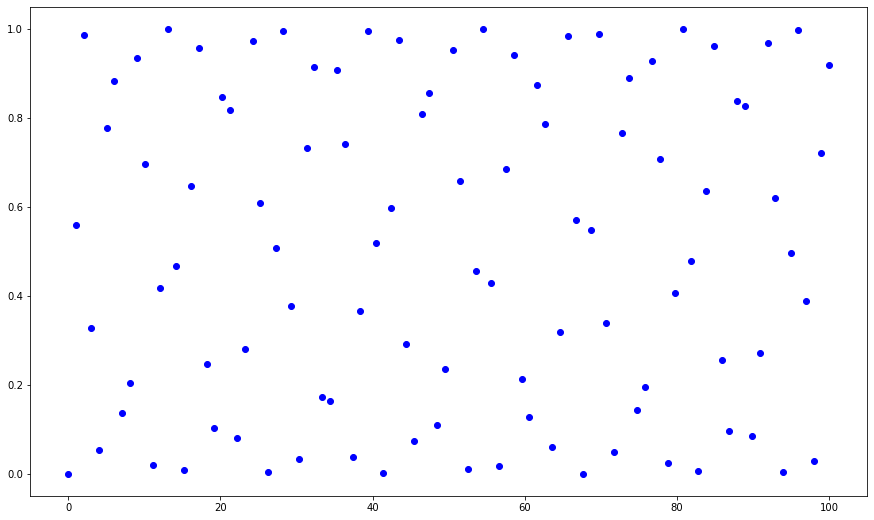

In [80]:
%matplotlib inline
# Fit the data to an oscillation

plt.figure(figsize=(15, 9))
initial_theta = 0.02
initial_c = 0.5
initial_phi = 0.1


fit = AmpCalFitter(backend_result1, xdata, qubits,
                   fit_p0=[initial_theta, initial_c],
                   fit_bounds=([-np.pi, -1],
                               [np.pi, 1]))

#fit.plot(0, ax=plt.gca())

#plot analytic function
x = np.linspace(0,100,100)
y = np.array(list(map(lambda x: 0.5 - 0.5*np.cos((0.1 + np.pi/2)*(x-1) +np.pi/2 + 0.1), x)))
plt.scatter(x,y, color='b')

print("Rotation Error on U2: %f rads"%(fit.angle_err()[0]))
plt.show()

In [46]:
circs, xdata = anglecal_1Q_circuits(20, qubits, angleerr=0.05)
# Set the simulator
# Run the simulator
backend = qiskit.Aer.get_backend('qasm_simulator')
shots = 8192
backend_result2 = qiskit.execute(circs, backend, shots=shots).result()

Angle error between X and Y: 0.049051059988503135


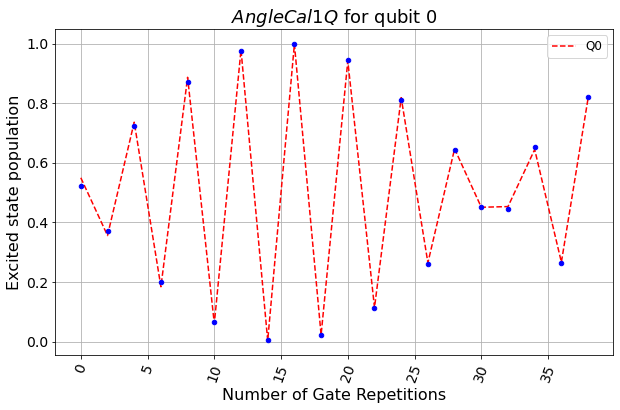

In [47]:
# Fit the data to an oscillation

plt.figure(figsize=(10, 6))
initial_theta = 0.02
initial_c = 0.5
initial_phi = 0.01


fit = AngleCalFitter(backend_result2, xdata, qubits,
                   fit_p0=[initial_theta, initial_c],
                   fit_bounds=([-np.pi, -1],
                               [np.pi, 1]))

fit.plot(0, ax=plt.gca())
print ("Angle error between X and Y: " + str(fit.angle_err()[0]))

plt.show()


In [97]:
batch = []
for p in np.linspace(-np.pi, np.pi, 20):
    circ = QuantumCircuit(1,1)
    circ.u3(qubit=0,lam=0,theta=0, phi=p)
    circ.measure(0,0)
    batch.append(circ)

In [101]:
job = qiskit.execute(batch, backend=backend, shots = 8192)

In [102]:
job.result().get_counts()

[{'1': 211, '0': 7981},
 {'1': 205, '0': 7987},
 {'1': 222, '0': 7970},
 {'1': 202, '0': 7990},
 {'1': 221, '0': 7971},
 {'1': 222, '0': 7970},
 {'1': 218, '0': 7974},
 {'1': 197, '0': 7995},
 {'1': 214, '0': 7978},
 {'1': 215, '0': 7977},
 {'1': 201, '0': 7991},
 {'1': 240, '0': 7952},
 {'1': 214, '0': 7978},
 {'1': 217, '0': 7975},
 {'1': 206, '0': 7986},
 {'1': 197, '0': 7995},
 {'1': 215, '0': 7977},
 {'1': 212, '0': 7980},
 {'1': 209, '0': 7983},
 {'1': 204, '0': 7988}]